In [1]:
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

sys.path.append(os.path.abspath('..'))
from figures.plots import show_embeddings
from models.model1 import Seq2SeqAutoencoder
from data.dataloading import TimeSeriesDataset, SequenceLengthSampler, pad_collate

import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

In [13]:
spec_cols = ['supplier_status', 'volume_contracted', 'spec_price', 'delivery_period_lenght']
delivery_cols = ['price_change', 'lateness_percentage', 'weight_percentage']
time_cols = ['month', 'day', 'weekday']

data = pd.read_csv('../data/final_data/data.csv')
dataset = TimeSeriesDataset(data, spec_cols, delivery_cols, time_cols)

bucket_boundaries = [2, 4, 6, 7, 10, 15, 20, 30, 40, 60, 80, 100, 140]
lengths = [(i, len(item[1])) for i, item in enumerate(dataset)]
sampler = SequenceLengthSampler(lengths, bucket_boundaries, batch_size=8)

dataloader = DataLoader(dataset, collate_fn=pad_collate, batch_sampler=sampler)

In [9]:
class Seq2SeqAutoencoder(nn.Module):
    """
    Модель автоэнкодера. Декодер работает по принципу копирования
    выхода из энкодера.
    """

    def __init__(self, seq_input_dim, meta_input_dim, seq_output_dim,
                 meta_output_dim, output_dim, num_layers=2):
        super(Seq2SeqAutoencoder, self).__init__()
        self.seq_input_dim = seq_input_dim
        self.meta_input_dim = meta_input_dim
        self.seq_output_dim = seq_output_dim
        self.meta_output_dim = meta_output_dim
        self.output_dim = output_dim
        
        self.fc_encoder = nn.Linear(meta_input_dim, meta_output_dim)
        self.seq_encoder = nn.LSTM(seq_input_dim, seq_output_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(meta_output_dim, output_dim, num_layers, batch_first=True)
        
    def forward(self, h, x):
        meta_vec = self.fc_encoder(h)
        _, (hidden, _) = self.seq_encoder(x)
        
        embed = (meta_vec + hidden[0]).unsqueeze(0)
        embed = embed.repeat(x.shape[1], 1, 1).permute(1, 0, 2)
        
        output, _ = self.decoder(embed)
        return output

In [14]:
model = Seq2SeqAutoencoder(3, 4, 10, 10, 3)

In [15]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [26]:
for epoch in range(100):
    accumulated_loss = []
    for i, (h, x, t) in enumerate(dataloader):
        output = model(h, x)
        loss = criterion(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accumulated_loss.append(loss.item())
        if i % 100 == 0 and i != 0:
            print(np.mean(accumulated_loss))
            accumulated_loss = []

0.40012187698837554


KeyboardInterrupt: 

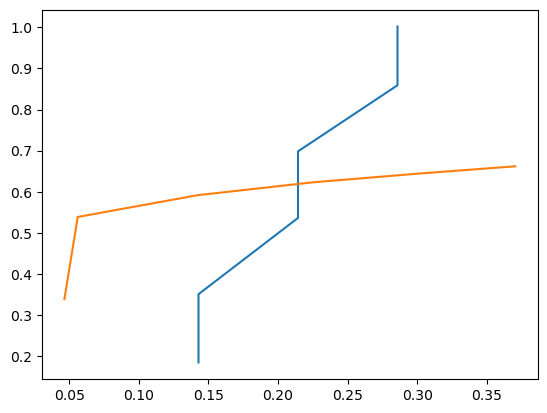

In [35]:
i = 7
plt.plot(x[i, :, -2], x[i, :, -1])
plt.plot(output[i, :, -2].detach(), output[i, :, -1].detach())

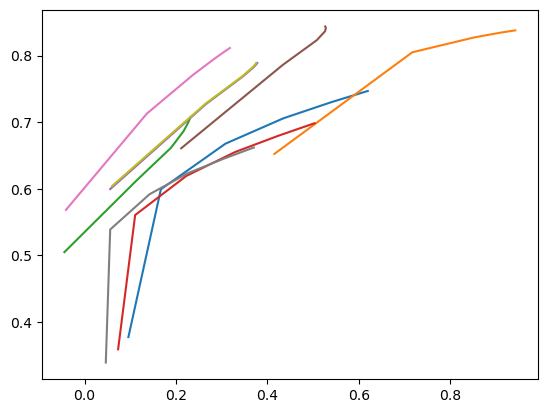

In [28]:
for i in range(len(output)):
    plt.plot(output[i, :, -2].detach(), output[i, :, -1].detach())

In [7]:
h, x, t = next(iter(dataloader))

In [24]:
output

tensor([[[-0.7353,  0.0739,  0.6105]],

        [[-0.7319,  0.0739,  0.6133]],

        [[ 0.3475,  0.1961,  0.5537]],

        [[ 0.1941,  0.2396,  0.5913]],

        [[-0.7078,  0.1023,  0.6356]],

        [[-0.3765,  0.1918,  0.6362]],

        [[-0.7334,  0.0727,  0.6094]],

        [[ 0.1206,  0.2291,  0.5942]]], grad_fn=<TransposeBackward0>)

In [36]:
x

tensor([[[ 0.9804,  0.1176,  0.1756],
         [ 1.3389,  0.1176,  0.3856],
         [ 1.0846,  0.1176,  0.5616],
         [ 0.0426,  0.6471,  0.7294],
         [-0.4138,  0.7647,  0.8890],
         [ 0.6678,  0.8235,  1.0624]],

        [[-0.7951,  0.2857,  0.1717],
         [ 0.5740,  0.4286,  0.3243],
         [-0.5471,  0.4286,  0.4922],
         [ 0.3261,  1.1429,  0.6616],
         [ 0.0135,  1.1429,  0.8293],
         [ 0.6386,  1.7143,  1.0000]],

        [[-0.8306,  0.1071,  0.1572],
         [-1.0765,  0.1429,  0.3157],
         [-0.2054,  0.1429,  0.4843],
         [-0.3283,  0.1429,  0.6160],
         [-0.2700,  0.1429,  0.7999],
         [-0.2054,  0.1786,  1.0055]],

        [[ 0.7408,  0.0667,  0.1990],
         [ 1.4660,  0.1778,  0.3497],
         [ 1.4389,  0.1778,  0.4965],
         [ 0.5615,  0.6444,  0.6659],
         [ 1.4451,  0.6444,  0.8063],
         [ 1.2284,  0.6444,  1.0038]],

        [[-1.9371,  0.1250,  0.1750],
         [-2.1705,  0.2083,  0.3465],
    

In [18]:
supplier_set = {
    'Барсукова Е.С. ИП Глава К(Ф)Х',
    'Донченко В.С. ИП Глава К(Ф)Х',
    'АГРОПРОМ ООО', 'ИНТЕРПРОМ ООО', 'ДОНСКИЕ ЗОРИ ООО'
}
indexes = np.where([
    (supplier in supplier_set) for supplier in dataset.supplier
])[0]

In [19]:
seqs = [dataset[i] for i in indexes]
suppliers = [dataset.supplier[i] for i in indexes]
embs = np.stack([model.encoder(seq.unsqueeze(0))[1][0].squeeze().detach().numpy() for seq in seqs])

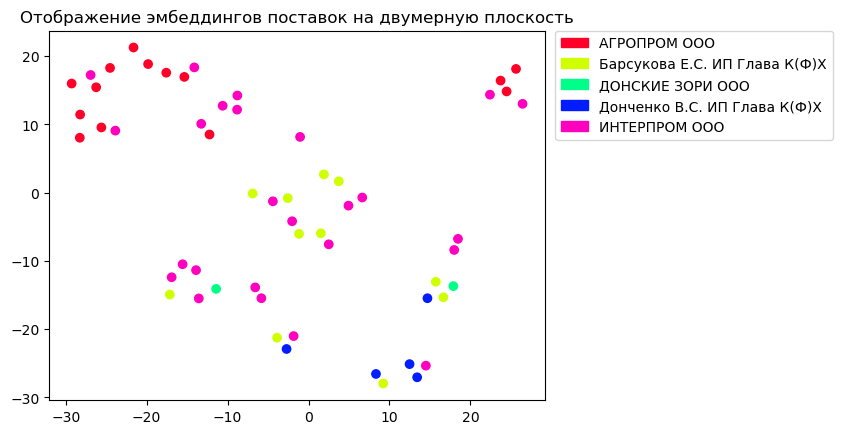

In [21]:
plt.title('Отображение эмбеддингов поставок на двумерную плоскость')
show_embeddings(embs, suppliers)
plt.savefig('../figures/tsne_spec_embedings.jpg', bbox_inches='tight')

In [93]:
X, y = next(iter(dataloader))

In [31]:
class BySequenceLengthSampler(Sampler):

    def __init__(self, ind_n_len, bucket_boundaries, batch_size=64,):
        self.ind_n_len = ind_n_len
        self.bucket_boundaries = bucket_boundaries
        self.batch_size = batch_size
        
        
    def __iter__(self):
        data_buckets = dict()
        # where p is the id number and seq_len is the length of this id number. 
        for p, seq_len in self.ind_n_len:
            pid = self.element_to_bucket_id(p,seq_len)
            if pid in data_buckets.keys():
                data_buckets[pid].append(p)
            else:
                data_buckets[pid] = [p]

        for k in data_buckets.keys():

            data_buckets[k] = np.asarray(data_buckets[k])

        iter_list = []
        for k in data_buckets.keys():
            np.random.shuffle(data_buckets[k])
            iter_list += (np.array_split(data_buckets[k]
                           , int(data_buckets[k].shape[0]/self.batch_size)))
        shuffle(iter_list) # shuffle all the batches so they arent ordered by bucket
        # size
        for i in iter_list: 
            yield i.tolist() # as it was stored in an array
    
    def __len__(self):
        return len(self.data_source)
    
    def element_to_bucket_id(self, x, seq_length):
        boundaries = list(self.bucket_boundaries)
        buckets_min = [np.iinfo(np.int32).min] + boundaries
        buckets_max = boundaries + [np.iinfo(np.int32).max]
        conditions_c = np.logical_and(
          np.less_equal(buckets_min, seq_length),
          np.less(seq_length, buckets_max))
        bucket_id = np.min(np.where(conditions_c))
        return bucket_id

In [124]:
lengths = torch.tensor([len(item) for item in data])
sampler = BucketBatchSampler(lengths, batch_size=2)
loader = torch.utils.data.DataLoader(dataset, batch_sampler=sampler, collate_fn=pad_collate)

In [125]:
lengths

tensor([3, 5, 2, 4])

In [126]:
X, y = next(iter(loader))

In [127]:
X

tensor([[1., 2., 0., 0.],
        [1., 2., 3., 4.]])

In [133]:
for X, y in loader:
    print(X)

tensor([[1., 2., 3., 4., 0.],
        [1., 2., 3., 4., 5.]])
tensor([[1., 2., 3.],
        [1., 2., 0.]])
